In [1]:
import pandas as pd
import datetime

In [3]:
movies = pd.read_csv('movielens/ml-20m/movies.csv', sep=',')
print(type(movies))
movies.head(15)

<class 'pandas.core.frame.DataFrame'>


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [5]:
ratings = pd.read_csv('movielens/ml-20m/ratings.csv', sep=',', parse_dates=['timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
ratings['rating'].mean()

3.5255285642993797

In [7]:
movies['year'] = movies['title'].str.extract('.*\((.*)\).*', expand=True)

In [8]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [9]:
ratings['parsed_time'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [10]:
ratings.head()

,userId,movieId,rating,timestamp,parsed_time
0,1,2,3.5,1112486027,2005-04-02 23:53:47
1,1,29,3.5,1112484676,2005-04-02 23:31:16
2,1,32,3.5,1112484819,2005-04-02 23:33:39
3,1,47,3.5,1112484727,2005-04-02 23:32:07
4,1,50,3.5,1112484580,2005-04-02 23:29:40


In [11]:
joined = ratings.merge(movies, on='movieId', how='inner')
joined.head()

,userId,movieId,rating,timestamp,parsed_time,title,genres,year
0,1,2,3.5,1112486027,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy,1995
1,5,2,3.0,851527569,1996-12-25 15:26:09,Jumanji (1995),Adventure|Children|Fantasy,1995
2,13,2,3.0,849082742,1996-11-27 08:19:02,Jumanji (1995),Adventure|Children|Fantasy,1995
3,29,2,3.0,835562174,1996-06-23 20:36:14,Jumanji (1995),Adventure|Children|Fantasy,1995
4,34,2,3.0,846509384,1996-10-28 13:29:44,Jumanji (1995),Adventure|Children|Fantasy,1995


In [12]:
def slice_movie_df(movie_df, movie_id, ratings_date_from, ratings_date_to):
    select_movie = movie_df['movieId'] == movie_id
    select_date_from = movie_df['parsed_time'] > ratings_date_from
    select_date_to = movie_df['parsed_time'] < ratings_date_to
    
    sliced_df = movie_df[select_movie & select_date_from & select_date_to]
    
    average_rating = sliced_df[['movieId','rating']].groupby('movieId', as_index=False).mean()
    
    avg_rating = average_rating['rating'].unique().tolist()[0]   
    votes_number = sliced_df.shape[0]
      
    return avg_rating, votes_number

def add_days_to_str_date(str_date, str_date_format='%Y-%m-%d', days=30):
    datetime_object = datetime.datetime.strptime(str_date, str_date_format)
    output_date = datetime_object + datetime.timedelta(days=days)
    
    return output_date.strftime(str_date_format)
    
def get_movie_id(movie_df, title_keyword):
    mask = movie_df['title'].str.contains(title_keyword)
    unique_ids = movie_df[mask]['movieId'].unique().tolist()
    unique_titles = movie_df[mask]['title'].unique().tolist()
   
    if len(unique_ids) > 0 and len(unique_ids) == len(unique_titles):
        return unique_ids[0], unique_titles[0]
    
    return None, None

    

In [13]:
period_size = 70 #number of days in one period
periods_number = 2 #number of periods before the date and after the date
movies_keywords = ["Apocalypse Now", "Full Metal Jacket", "Deer Hunter", "Born on the Fourth of July", "Platoon"]

the_date = '2001-10-07' #United States invasion of Afghanistan

In [14]:
starting_date = add_days_to_str_date(str_date=the_date, days=-1*period_size*periods_number)

periods_dates = []
periods = []

for period_number in range(0, periods_number*2+1):
    this_date = add_days_to_str_date(str_date=starting_date, days=period_number*period_size)
    periods_dates.append(this_date)
    
for pos in range(len(periods_dates)-1):
    start_date = periods_dates[pos]
    end_date = periods_dates[pos+1]
    periods.append([start_date, end_date])
    
periods_labels = ["{}:{}".format(s,e) for s,e in periods]

In [15]:
output_data = []
valid_movie_titles = []

for movie_keyword in movies_keywords:
    the_movie_id, the_movie_title = get_movie_id(joined, movie_keyword)
    
    if the_movie_id != None and the_movie_title != None:
        print(the_movie_title)
        valid_movie_titles.append(the_movie_title)

        this_ratings = []   
        for start_date,end_date in periods:
            avg_rating, votes_number = slice_movie_df(movie_df=joined, 
                                                      movie_id=the_movie_id,
                                                      ratings_date_from=start_date, 
                                                      ratings_date_to=end_date)
            print(start_date, "-", end_date, " >>> ", avg_rating, "[", votes_number, "]")
            this_ratings.append(avg_rating)

        print("------------------------------------------------------------")

        this_movie_row = dict(zip(periods_labels, this_ratings))
        output_data.append(this_movie_row)
    
output_df = pd.DataFrame(output_data, index=valid_movie_titles)
output_df

Apocalypse Now (1979)
2001-05-20 - 2001-07-29  >>>  4.146853146853147 [ 286 ]
2001-07-29 - 2001-10-07  >>>  4.111111111111111 [ 243 ]
2001-10-07 - 2001-12-16  >>>  4.191256830601093 [ 183 ]
2001-12-16 - 2002-02-24  >>>  4.294392523364486 [ 214 ]
------------------------------------------------------------
Full Metal Jacket (1987)
2001-05-20 - 2001-07-29  >>>  4.0852272727272725 [ 528 ]
2001-07-29 - 2001-10-07  >>>  4.087403598971722 [ 389 ]
2001-10-07 - 2001-12-16  >>>  4.054838709677419 [ 310 ]
2001-12-16 - 2002-02-24  >>>  4.161458333333333 [ 192 ]
------------------------------------------------------------
Deer Hunter, The (1978)
2001-05-20 - 2001-07-29  >>>  4.073033707865169 [ 178 ]
2001-07-29 - 2001-10-07  >>>  4.078125 [ 128 ]
2001-10-07 - 2001-12-16  >>>  4.082644628099174 [ 121 ]
2001-12-16 - 2002-02-24  >>>  4.224299065420561 [ 107 ]
------------------------------------------------------------
Born on the Fourth of July (1989)
2001-05-20 - 2001-07-29  >>>  3.240875912408759 

,2001-05-20:2001-07-29,2001-07-29:2001-10-07,2001-10-07:2001-12-16,2001-12-16:2002-02-24
Apocalypse Now (1979),4.146853,4.111111,4.191257,4.294393
Full Metal Jacket (1987),4.085227,4.087404,4.054839,4.161458
"Deer Hunter, The (1978)",4.073034,4.078125,4.082645,4.224299
Born on the Fourth of July (1989),3.240876,3.528302,3.269231,3.440860
Platoon (1986),4.079518,3.993355,4.051948,4.072368


[Text(0,0,'0'),
 Text(0,0,'2001-05-20:2001-07-29'),
 Text(0,0,'2001-07-29:2001-10-07'),
 Text(0,0,'2001-10-07:2001-12-16'),
 Text(0,0,'2001-12-16:2002-02-24')]

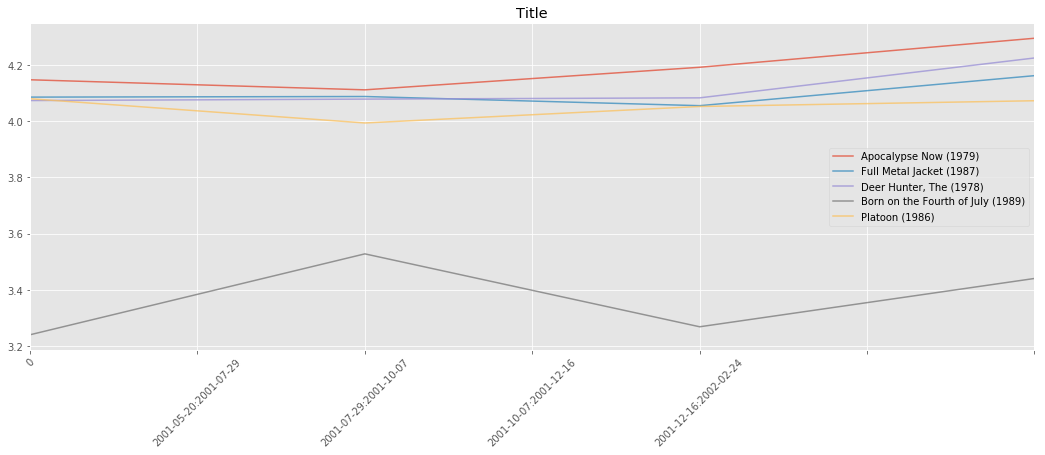

In [16]:
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

ax = output_df.T.plot(kind="line", figsize=(18,6), title="Title", grid=True, use_index=True, alpha=0.75)
ax.set_xticklabels([0]+periods_labels, rotation=45)
